# Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the distance to the nearest facility in meters

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [3]:
# Get reference to GOSTNets
sys.path.append(r'C:\\Users\\Rosem\\Documents\\Career\\World Bank\\City Scan\\repo\\GOSTnets')
import GOSTnets as gn

In [4]:
from GOSTnets.fetch_pois import *

### Define folders and files

In [5]:
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [6]:
city_name = 'Khartoum'

In [7]:
origins_file = os.path.join(inputFolder, "Khartoum_world_pop_pts.shp")

In [8]:
# import extent
city_extent = gpd.read_file("./admin/Khartoum_AOI_4326.shp")

In [9]:
# make sure crs is 4326
print(city_extent.crs)

epsg:4326


In [10]:
extent = box(*city_extent.total_bounds)

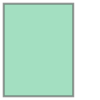

In [11]:
extent

## We will extract OSM POIs

In [12]:
school_tags = {'amenity':['school', 'kindergarten', 'university', 'college']}
# Remove pharmacy from health_tags
health_tags = {'amenity':['clinic', 'hospital', 'health']}
# health_tags = {'amenity':['clinic', 'pharmacy', 'hospital', 'health']}
# Also get police and fire stations for flood maps
police_tags = {'amenity':['police']}
fire_tags = {'amenity':['fire_station']}

In [13]:
tag_dictionary = {'schools': school_tags, 'health': health_tags,
                  'police': police_tags, 'fire': fire_tags}

In [38]:
queries = {}
for tags in tag_dictionary.items():
    print(tags[0])
    # create the OsmObject
    queries[tags[0]] = OsmObject(f'{tags[0]}', extent, tags[1])
query_results_gpd_dict = {}
for query in queries.items():
    print(query)
    query[1].GenerateOSMPOIs()
    query[1].RemoveDupes(0.0005)
    
    try:
        query_results = query[1].df[['amenity','geometry','name']]
    except KeyError:
        query_results = query[1].df[['amenity','geometry']]
    
    # convert to GeoDataFrame
    query_results_gpd = gpd.GeoDataFrame(query_results, crs = "epsg:4326", geometry = 'geometry')
    query_results_gpd.to_file(outputFolder + f'/osm_infrastructure/osm_{query[0]}.shp')
    
    #save result in query_results_gpd_dict 
    query_results_gpd_dict[query[0]] = query_results_gpd

police
fire
('police', <GOSTnets.fetch_pois.OsmObject object at 0x000002010B8A5340>)


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype ex

('fire', <GOSTnets.fetch_pois.OsmObject object at 0x000002010B8A5100>)


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype ex

## We will extract the Roads and convert into a graph

In [15]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largerst subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

<class 'networkx.utils.decorators.argmap'> compilation 5:5: DeprecationWarning: read_gpickle is deprecated and will be removed in 3.0.Use ``pickle.load(path)``
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\core.py:1002: UserWarning: Aree you sure you want to convert length to time? This graph already has a time attribute


### Inspect the road graph as a shapefile

In [16]:
roads = gn.edge_gdf_from_graph(G)

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
roads[:2]

,stnode,endnode,mode,width,oneway,highway,name,osmid,lanes,junction,service,maxspeed,tunnel,time,bridge,access,length,geometry
0,35468181,302320229,drive,NaN,True,secondary,دوران حديقة القرشي,43122153,NaN,NaN,NaN,NaN,NaN,7.41492,NaN,NaN,61.791,"LINESTRING (32.53164 15.58386, 32.53168 15.583..."
1,35490920,3294007090,drive,NaN,True,secondary,شارع الصحافة,327372312,NaN,NaN,NaN,NaN,NaN,1.01832,NaN,NaN,8.486,"LINESTRING (32.53389 15.57864, 32.53387 15.57871)"


In [19]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

## Snap origins to the road graph using advanced snapping

In [20]:
# insert origins
origins = gpd.read_file(origins_file)

In [21]:
origins['osmid'] = 1110000000 + origins.index
origins

,VALUE,geometry,osmid
0,24.834244,POINT (32.60000 15.89083),1110000000
1,23.445583,POINT (32.60083 15.89083),1110000001
2,28.320116,POINT (32.60167 15.89083),1110000002
3,22.066607,POINT (32.58417 15.88917),1110000003
4,44.561417,POINT (32.57833 15.88833),1110000004
...,...,...,...
136096,15.983064,POINT (32.49333 15.19000),1110136096
136097,8.468939,POINT (32.49417 15.19000),1110136097
136098,9.722957,POINT (32.49500 15.19000),1110136098
136099,10.808292,POINT (32.49583 15.19000),1110136099


In [22]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)
G_utm

'+proj=utm +zone=36 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [23]:
%%time
G2, pois_meter, new_footway_edges = gn.advanced_snap(G, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='osmid', poi_key_col='osmid', path=None, threshold=2000, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
print _new_nodes
Updating internal edges...
Updating external links...
node count before: 484484
node count after: 483371
pois_meter count before: 136101
pois_meter count after: 134988
Remove edge projections greater than threshold: 1113/136101 (0.82%)
NOTE: duplication in node coordinates keys
Nodes count: 483371
Node coordinates key count: 484484
Missing 'from' nodes: 0
Missing 'to' nodes: 0
making a new graph from edges and nodes
Wall time: 7h 38min


In [24]:
originNodes_list = list(origins['osmid'])

### Snap destinations to the road graph

In [25]:
snapped_destinations_dict = {}
for results_gpd in query_results_gpd_dict.items():
    snapped_destinations = gn.pandana_snap(G, query_results_gpd_dict[results_gpd[0]])
    snapped_destinations_dict[results_gpd[0]] = list(snapped_destinations['NN'].unique())

In [26]:
# snapped_destinations_dict

## Isochrones processing

In [27]:
G2

In [28]:
threshold_list = {
    'schools': [800,1600,2400],
    'health': [1000,2000,3000]
}

def isochrone_processing(amenity_type):
    amenity_threshold_list = threshold_list.get(amenity_type)
    if amenity_threshold_list == None:
        return "Amenity type not found"
    for threshold in amenity_threshold_list:
        print(threshold)
        iso_gdf = gn.make_iso_polys(G2, snapped_destinations_dict[amenity_type], [threshold], edge_buff=300, node_buff=300, weight = 'length', measure_crs = G_utm)
        dissolved = iso_gdf.dissolve(by="thresh")
        gdf_out = dissolved.explode()
        gdf_out2 = gdf_out.reset_index()
        # save file
        gdf_out2.to_file(outputFolder + f'/{city_name}_AOI_accessibility_{amenity_type}_isochrones_{threshold}m.shp')

In [29]:
isochrone_processing('schools')

800
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetchin

unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtyp

1600
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetchin

unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtyp

2400
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetchin

unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtyp

In [30]:
isochrone_processing('health')

1000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception w

2000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetchin

unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtyp

3000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetchin

unary_union


C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan_gpd_0.9\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtyp